In [2]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
import numpy.linalg as la

In [3]:
# drone properties
# for rotational dynamics, Tait-Bryan ZYX was used
l = .359210 # m (length of an arm)
R = .08 # m (radius of rotor)
A = np.pi * R**2 # m^2 (area of a rotor)
m = .96373 # kg (mass of drone)
g = 9.81 # m/s^2
kt = 1.25*(10**-5) # thrust coefficient for rotors (estimated to be constant for model simplicity)
km = 1.25*(10**-7) # moment coefficient for rotors (estimated to be constant for model simplicity)
I = np.diag([20.7, 20.7, 41.4]) # intertia matrix, update w actual values, TBD
rho = 1.225 # kg/m^3 (density of air)

# define initial conditions for the drone!

# position (meters)
r_x, r_y, r_z = 0, 0, 0
r = np.array([r_x, r_y, r_z])

# roll, pitch, yaw angles (radians)
phi, theta, psi = 0, 0, 0
eulers = np.array([phi, theta, psi])

phidot, thetadot, psidot = 0, 0, 0
euler_dot = np.array([phidot, thetadot, psidot])

# linear velocity (m/s)
v_x, v_y, v_z = 0, 0, 0
v = np.array([v_x, v_y, v_z])

# angular velocity of drone in body frame (rad/s)
w_x, w_y, w_z = 0, 0, 0
w = np.array([w_x, w_y, w_z])

# rotor torques
tau_phi, tau_theta, tau_psi = 0, 0, 0
tau = np.array([tau_phi, tau_theta, tau_psi])

# rotor rotations
w1, w2, w3, w4 = 0, 0, 0, 0
rotors = np.array([w1, w2, w3, w4])

# translational acceleration and force
a = np.array([0, 0, -g])
f = m*a

# rotation matrix
# from chapter 6 slides, slide 68
def R_zyx(phi, theta, psi):
    #roll, φ, is about x-axis
    #pitch, θ, is about y-axis
    #yaw, ψ, is about z-axis
    roll = np.array([[1, 0, 0],
                     [0, np.cos(phi), -np.sin(phi)],
                     [0, np.sin(phi), np.cos(phi)]])
    pitch = np.array([[np.cos(theta), 0, np.sin(theta)],
                      [0, 1, 0],
                      [-np.sin(theta), 0, np.cos(theta)]])
    yaw = np.array([[np.cos(psi), -np.sin(psi), 0],
                    [np.sin(psi), np.cos(psi), 0],
                    [0, 0, 1]])
    return yaw @ pitch @ roll

#useful funcs
# get_euler_rates from chapter 6 slides, slide 68
def get_euler_rates(psi, theta, p, q, r): # finding euler angle rates, general
    coeffs = (1/np.cos(theta)) * np.array([
                        [0, np.sin(psi), np.cos(psi)],
                        [0, np.cos(theta)*np.cos(psi), -np.sin(psi)*np.cos(theta)],
                        [np.cos(theta), np.sin(theta)*np.sin(psi), np.sin(theta)*np.cos(psi)]])
    return coeffs @ np.array([p, q, r])

# get_omegas_body from chapter 6 slides, slide 68
def get_omegas_body(phidot, thetadot, psidot, theta, psi): # finding omegas in body frame (p, q, r), general
    coeffs = np.array([[-np.sin(theta), 0, 1],
                       [np.cos(theta)*np.sin(psi), np.cos(psi), 0],
                       [np.cos(theta)*np.cos(psi), -np.sin(psi), 0]])
    return coeffs @ np.array([phidot,thetadot,psidot])

def get_fam(rotors): # finding forces (in body frame) and moments, general
    w1, w2, w3, w4 = rotors
    #rotor arrangement: 1 @ (l,0,0) is CW, 2 @ (0,l,0) is CCW, 3 @ (-l,0,0) is CW, 4 # (0,-l,0) is CCW
    #so 1+3 control pitch, 2+4 control roll
    T1, T2, T3, T4 = kt * w1**2, kt * w2**2, kt * w3**2, kt * w4**2
    thrust_tot = T1 + T2 + T3 + T4
    
    tau_phi = l * (T2 - T4)
    tau_theta = l * (T3 - T1)
    tau_psi = km * (w1**2 - w2**2 + w3**2 - w4**2)
    return np.array([0,0,thrust_tot]), np.array([tau_phi, tau_theta, tau_psi])

def step(rin, vin, eulersin, win, rotorsin, dt): # returns all necessary parameters (position, velocity, euler angles, body omegas, rotor rotations) after a time step of dt
    T, tau = get_fam(rotorsin)
    
    # rotational
    domega = la.inv(I) @ (tau - np.cross(win, I@win))
    wout = win + dt*domega
    dphi, dtheta, dpsi = get_euler_rates(eulers[2], eulersin[1], wout[0], wout[1], wout[2])
    eulersout = eulersin + np.array([dphi*dt, dtheta*dt, dpsi*dt])

    # translational
    R = R_zyx(eulersout[0], eulersout[1], eulersout[2])
    fout = R@T - np.array([0,0,m*g])
    aout = fout/m 
    vout = vin + aout*dt 
    rout = rin + vout*dt 

    return rout, vout, aout, fout, eulersout, wout

In [4]:
# Task 1. Hover at 1m for 2 mins. Rotors instantaneously start rotating at t = 0.
def task1(t_tot, ro, vo, ao, fo, eulerso, wo):
    t = 0
    dt = .1
    
    r = ro
    v = vo
    a = ao
    eulers = eulerso
    w = wo

    tovertime = []
    rovertime = []
    vovertime = []
    eulersovertime = []
    powerovertime = []
    rotorovertime = []

    # set initial conditions!
    r = np.array([0, 0, 1])

    thrust_des_rotor = (m * 9.81) / 4
    rotors = np.sqrt(thrust_des_rotor / kt), -np.sqrt(thrust_des_rotor / kt), np.sqrt(thrust_des_rotor / kt), -np.sqrt(thrust_des_rotor / kt)
    power = 4 * thrust_des_rotor * np.sqrt(thrust_des_rotor / (2*A*rho)) #P = T sqrt(T/A2rho)
    
    while (t < t_tot):
        r, v, a, f, eulers, w = step(r, v, eulers, w, rotors, dt)
        tovertime.append(t)
        rovertime.append(r)
        vovertime.append(v)
        eulersovertime.append(eulers)
        powerovertime.append(power)
        rotorovertime.append(rotors)
        t += dt
    return tovertime, rovertime, vovertime, eulersovertime, powerovertime
t_t, r_t, v_t, eulers_t, power_t = task1(120, r, v, a, f, eulers, w)

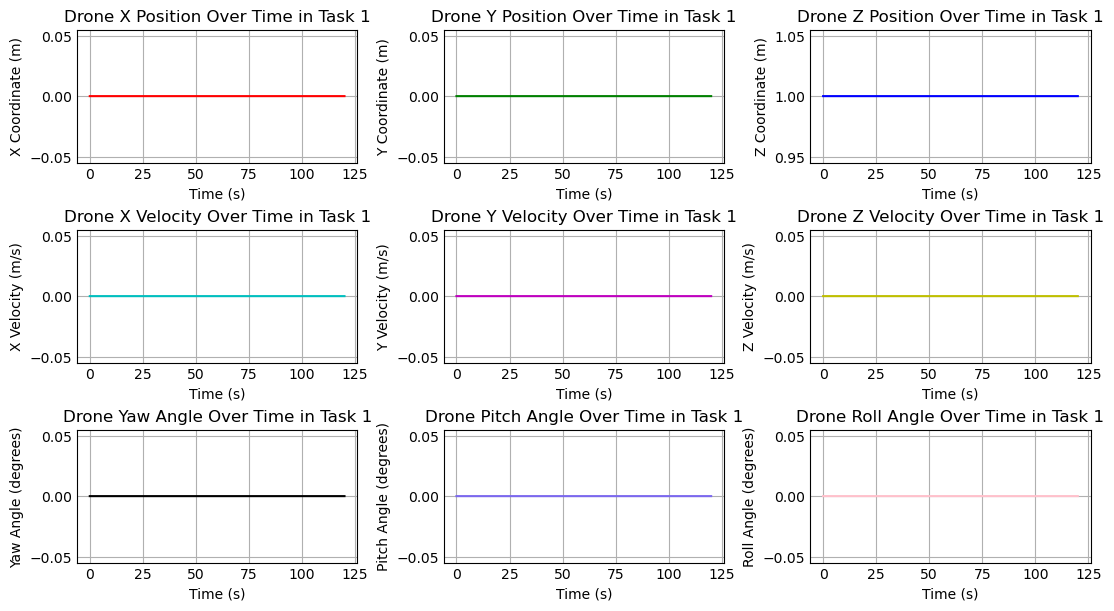

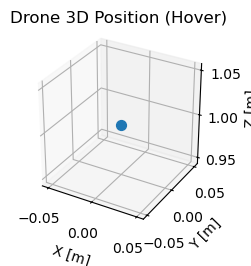

Text(0.5, 1.0, 'Drone Power Use Over Time')

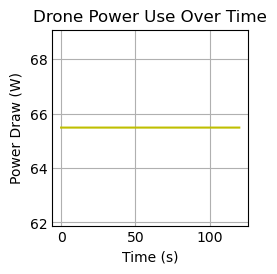

In [5]:
plt.style.use('_mpl-gallery')
r_tx = np.array(r_t).T[0]
r_ty = np.array(r_t).T[1]
r_tz = np.array(r_t).T[2]

v_tx = np.array(v_t).T[0]
v_ty = np.array(v_t).T[1]
v_tz = np.array(v_t).T[2]

phi_t = np.rad2deg(np.array(eulers_t).T[0])
theta_t = np.rad2deg(np.array(eulers_t).T[1])
psi_t = np.rad2deg(np.array(eulers_t).T[2])

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(11, 6), layout="constrained")
axs[0][0].plot(t_t, r_tx, 'r-')
axs[0][0].set_title('Drone X Position Over Time in Task 1', )
axs[0][0].set_xlabel('Time (s)')
axs[0][0].set_ylabel('X Coordinate (m)')

axs[0][1].plot(t_t, r_ty, 'g-')
axs[0][1].set_title('Drone Y Position Over Time in Task 1')
axs[0][1].set_xlabel('Time (s)')
axs[0][1].set_ylabel('Y Coordinate (m)')

axs[0][2].plot(t_t, r_tz, 'b-')
axs[0][2].set_title('Drone Z Position Over Time in Task 1')
axs[0][2].set_xlabel('Time (s)')
axs[0][2].set_ylabel('Z Coordinate (m)')

axs[1][0].plot(t_t, v_tx, 'c-')
axs[1][0].set_title('Drone X Velocity Over Time in Task 1', )
axs[1][0].set_xlabel('Time (s)')
axs[1][0].set_ylabel('X Velocity (m/s)')

axs[1][1].plot(t_t, v_ty, 'm-')
axs[1][1].set_title('Drone Y Velocity Over Time in Task 1')
axs[1][1].set_xlabel('Time (s)')
axs[1][1].set_ylabel('Y Velocity (m/s)')

axs[1][2].plot(t_t, v_tz, 'y-')
axs[1][2].set_title('Drone Z Velocity Over Time in Task 1')
axs[1][2].set_xlabel('Time (s)')
axs[1][2].set_ylabel('Z Velocity (m/s)')

axs[2][0].plot(t_t, phi_t, 'k-')
axs[2][0].set_title('Drone Yaw Angle Over Time in Task 1', )
axs[2][0].set_xlabel('Time (s)')
axs[2][0].set_ylabel('Yaw Angle (degrees)')

axs[2][1].plot(t_t, theta_t, color = 'mediumslateblue', linestyle = '-')
axs[2][1].set_title('Drone Pitch Angle Over Time in Task 1')
axs[2][1].set_xlabel('Time (s)')
axs[2][1].set_ylabel('Pitch Angle (degrees)')

axs[2][2].plot(t_t, psi_t, color = 'pink', linestyle = '-')
axs[2][2].set_title('Drone Roll Angle Over Time in Task 1')
axs[2][2].set_xlabel('Time (s)')
axs[2][2].set_ylabel('Roll Angle (degrees)')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(r_tx, r_ty, r_tz, linewidth=2)
ax.scatter(r_tx[0], r_ty[0], r_tz[0], marker='o', s=50)  # start point

# Labels and formatting
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title('Drone 3D Position (Hover)')

ax.set_box_aspect([1, 1, 1])  # equal scaling
ax.grid(True)

plt.show()

plt.figure()
plt.plot(t_t, power_t, 'y-')
plt.xlabel('Time (s)')
plt.ylabel('Power Draw (W)')
plt.title('Drone Power Use Over Time')

In [14]:
# Task 2. 
TBD = 1
def quad_allocation(thrust, tau_phi, tau_theta, tau_psi):
    A = np.array([[kt, kt, kt, kt],
                  [0, l*kt, 0, -l*kt],
                  [-l*kt, 0, l*kt, 0],
                  [km, -km, km, -km]])
    b = np.array([thrust, tau_phi, tau_theta, tau_psi])
    omega_sq = la.solve(A, b)
    omega = np.sqrt(omega_sq)
    thrusts = kt * omega_sq
    motor_torque = km * omega_sq
    mech_power = motor_torque * omega
    elec_power = mech_power / TBD
    return omega, elec_power

def task2(radius, vtarget, t_tot, ro, vo, ao, fo, eulerso, wo):
    dt = .01 #how often it updates
    t = 0
    r = ro
    v = vo
    a = ao
    eulers = eulerso
    w = wo
    
    tovertime = []
    rovertime = []
    vovertime = []
    eulersovertime = []
    powerovertime = []
    
    #set initial conditions!
    angular_velocity = vtarget/radius
    pitch_desired = np.arctan((vtarget**2 / radius) / g)
    
    eulers = np.array([0, -pitch_desired, 0])
    r = np.array([radius, 0, 1])
    v = np.array([0, vtarget, 0])
    w = np.array([0, 0, angular_velocity])

    while (t < t_tot):
        alpha_des = w[2] * t #where the drone should be along the circular path
        r_des = np.array([radius*np.cos(alpha_des), radius*np.sin(alpha_des), 1])
        altitude_change = r_des[2] - r[2] #need to mitigate altitude change in case we moved to stay at 1m
        
        f_z = m*g + (0.3 * altitude_change) - (0.1 * v[2]) #simple pd controller
        f_c = m*(vtarget**2 / radius)
        
        T = la.norm(f_c + f_z) #thrust produced by drone
        power = T * np.sqrt(T/(A*2*rho)) #P = T sqrt(T/A2rho)

        thrust_des_rotor = T / 4
        rotors = np.sqrt(thrust_des_rotor / kt), -np.sqrt(thrust_des_rotor / kt), np.sqrt(thrust_des_rotor / kt), -np.sqrt(thrust_des_rotor / kt)

        total_force_des = np.array([-f_c*np.cos(alpha_des), -f_c*np.sin(alpha_des), f_z - m*g])
        a = total_force_des / m
        v = v + a*dt
        r = r + v*dt
        eulers = eulers + np.array([0, 0, angular_velocity*dt]) #yaw changes at same rate as angular velocity of the overall circular path

        tovertime.append(t)
        rovertime.append(r)
        vovertime.append(v)
        eulersovertime.append(eulers)
        powerovertime.append(power)
        t += dt
    return tovertime, rovertime, vovertime, eulersovertime, powerovertime
t_t, r_t, v_t, eulers_t, power_t = task2(2, .5, 60, r, v, a, f, eulers, w)

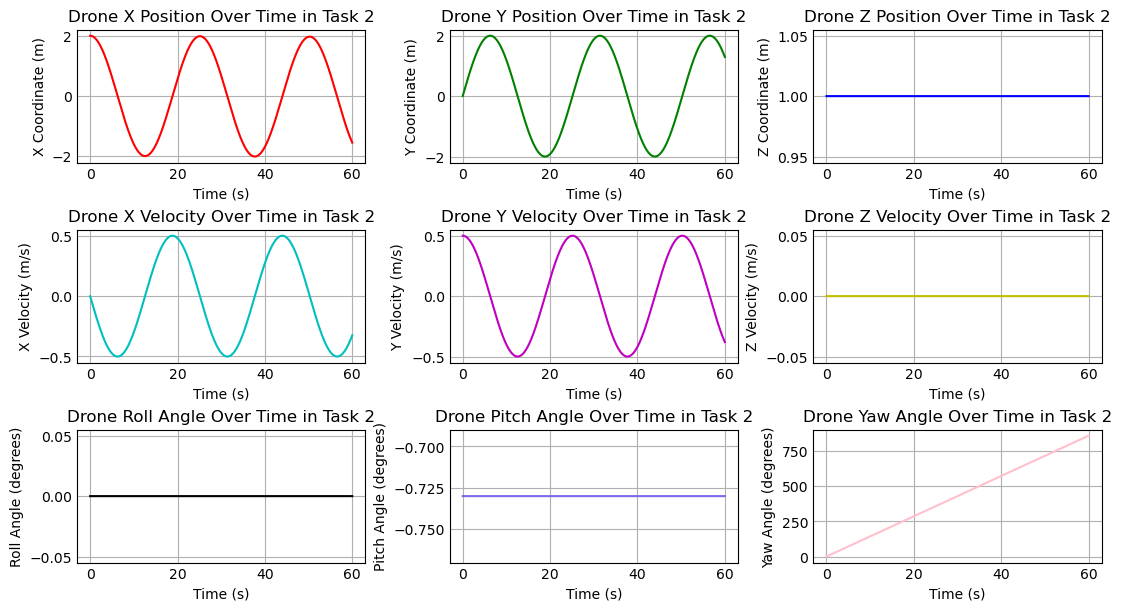

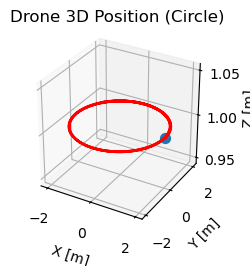

Text(0.5, 1.0, 'Drone Power Use Over Time')

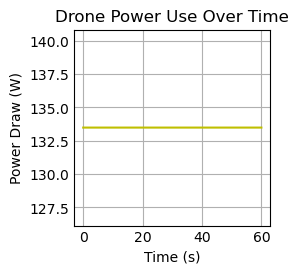

In [15]:
plt.style.use('_mpl-gallery')
r_tx = np.array(r_t).T[0]
r_ty = np.array(r_t).T[1]
r_tz = np.array(r_t).T[2]

v_tx = np.array(v_t).T[0]
v_ty = np.array(v_t).T[1]
v_tz = np.array(v_t).T[2]

phi_t = np.rad2deg(np.array(eulers_t).T[0])
theta_t = np.rad2deg(np.array(eulers_t).T[1])
psi_t = np.rad2deg(np.array(eulers_t).T[2])

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(11, 6), layout="constrained")
axs[0][0].plot(t_t, r_tx, 'r-')
axs[0][0].set_title('Drone X Position Over Time in Task 2', )
axs[0][0].set_xlabel('Time (s)')
axs[0][0].set_ylabel('X Coordinate (m)')

axs[0][1].plot(t_t, r_ty, 'g-')
axs[0][1].set_title('Drone Y Position Over Time in Task 2')
axs[0][1].set_xlabel('Time (s)')
axs[0][1].set_ylabel('Y Coordinate (m)')

axs[0][2].plot(t_t, r_tz, 'b-')
axs[0][2].set_title('Drone Z Position Over Time in Task 2')
axs[0][2].set_xlabel('Time (s)')
axs[0][2].set_ylabel('Z Coordinate (m)')

axs[1][0].plot(t_t, v_tx, 'c-')
axs[1][0].set_title('Drone X Velocity Over Time in Task 2', )
axs[1][0].set_xlabel('Time (s)')
axs[1][0].set_ylabel('X Velocity (m/s)')

axs[1][1].plot(t_t, v_ty, 'm-')
axs[1][1].set_title('Drone Y Velocity Over Time in Task 2')
axs[1][1].set_xlabel('Time (s)')
axs[1][1].set_ylabel('Y Velocity (m/s)')

axs[1][2].plot(t_t, v_tz, 'y-')
axs[1][2].set_title('Drone Z Velocity Over Time in Task 2')
axs[1][2].set_xlabel('Time (s)')
axs[1][2].set_ylabel('Z Velocity (m/s)')

axs[2][0].plot(t_t, phi_t, 'k-')
axs[2][0].set_title('Drone Roll Angle Over Time in Task 2', )
axs[2][0].set_xlabel('Time (s)')
axs[2][0].set_ylabel('Roll Angle (degrees)')

axs[2][1].plot(t_t, theta_t, color = 'mediumslateblue', linestyle = '-')
axs[2][1].set_title('Drone Pitch Angle Over Time in Task 2')
axs[2][1].set_xlabel('Time (s)')
axs[2][1].set_ylabel('Pitch Angle (degrees)')

axs[2][2].plot(t_t, psi_t, color = 'pink', linestyle = '-')
axs[2][2].set_title('Drone Yaw Angle Over Time in Task 2')
axs[2][2].set_xlabel('Time (s)')
axs[2][2].set_ylabel('Yaw Angle (degrees)')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(r_tx, r_ty, r_tz, 'r-', linewidth=2)
ax.scatter(r_tx[0], r_ty[0], r_tz[0], marker='o', s=50)  # start point

# Labels and formatting
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title('Drone 3D Position (Circle)')

ax.set_box_aspect([1, 1, 1])  # equal scaling
ax.grid(True)
plt.show()

plt.figure()
plt.plot(t_t, power_t, 'y-')
plt.xlabel('Time (s)')
plt.ylabel('Power Draw (W)')
plt.title('Drone Power Use Over Time')

In [16]:
# Task 3. Launch from ground and ascend vertically until 1m above ground. Move in a straight line 1m above ground at an average speed of 1m/s for 5m,
# stop (hover), yaw 90 deg to the left, move in another straight line for 5m, stop (hover), land vertically with a speed of no more than 1cm/s.
def task3(h_tot, ro, vo, ao, fo, eulerso, wo):
    t = 0
    dt = .01 #how often it updates

    r = ro
    v = vo
    a = ao
    eulers = eulerso
    w = wo
    
    tovertime = []
    rovertime = []
    vovertime = []
    eulersovertime = []
    powerovertime = []
    rotorovertime = []

    # initial rotor speed update
    thrust_perrotor = .01 + ((m * 9.81) / 4)
    rotors = np.array([np.sqrt(thrust_perrotor/kt), -np.sqrt(thrust_perrotor/kt), np.sqrt(thrust_perrotor/kt), -np.sqrt(thrust_perrotor/kt)]) # T = k w^2
    power = 4 * np.sqrt(thrust_perrotor**3 / (2*1.225*np.pi*(R**2)))

    ###STEP 1: Launch from ground and ascend vertically until 1m above ground. Will slow when close to target height
    while (r[2] < h_tot):
        r, v, a, f, eulers, w = step(r, v, eulers, w, rotors, dt)
        tovertime.append(t)
        rovertime.append(r)
        vovertime.append(v)
        eulersovertime.append(eulers)
        powerovertime.append(power)
        rotorovertime.append(rotors)

        if r[2] >= .975*h_tot:
            # update rotor speeds
            thrust_perrotor = 1.0001*((m * 9.81) / 4)
            rotors = np.array([np.sqrt(thrust_perrotor/kt), -np.sqrt(thrust_perrotor/kt), np.sqrt(thrust_perrotor/kt), -np.sqrt(thrust_perrotor/kt)])
        if r[2] >= .99*h_tot:
            # update rotor speeds
            thrust_perrotor = 1.00001*((m * 9.81) / 4)
            rotors = np.array([np.sqrt(thrust_perrotor/kt), -np.sqrt(thrust_perrotor/kt), np.sqrt(thrust_perrotor/kt), -np.sqrt(thrust_perrotor/kt)])
        if r[2] > .9995*h_tot:
            break
        t += dt

    #return to hover rotor speeds before start step 2!!

    az_target = -v[2]/(10*dt)
    thrust_needed = np.array([0,0,(m*(g+az_target))])
    for i in range(10):
        rotors = np.array([np.sqrt(.25*thrust_needed[2] /kt), -np.sqrt(.25*thrust_needed[2] /kt), np.sqrt(.25*thrust_needed[2] /kt), -np.sqrt(.25*thrust_needed[2] /kt)])
        r, v, a, f, eulers, w = step(r, v, eulers, w, rotors, dt)
        t += dt
    t_curr = t
    #hovering, now can move forward
    while (t < t_curr+5):
        v = np.array([1, 0, 0])
        r = r + v*dt
        
        tovertime.append(t)
        rovertime.append(r)
        vovertime.append(v)
        eulersovertime.append(eulers)
        powerovertime.append(power)
        rotorovertime.append(rotors)
        t += dt
    t_curr = t
    eulers = np.array([0, 0, -np.pi/2])
    while (t < t_curr+5):
        v = np.array([0, 1, 0])
        r = r + v*dt
        
        tovertime.append(t)
        rovertime.append(r)
        vovertime.append(v)
        eulersovertime.append(eulers)
        powerovertime.append(power)
        rotorovertime.append(rotors)
        t += dt
    while (r[2] > 0):
        v = np.array([0, 0, -.001])
        r = r + v*dt
        
        tovertime.append(t)
        rovertime.append(r)
        vovertime.append(v)
        eulersovertime.append(eulers)
        powerovertime.append(power)
        rotorovertime.append(rotors)
        t += dt
    
    return tovertime, rovertime, vovertime, eulersovertime, powerovertime, rotorovertime

t_t, r_t, v_t, eulers_t, power_t, _ = task3(1, r, v, a, f, eulers, w)

Text(0.5, 1.0, 'Drone Power Use Over Time')

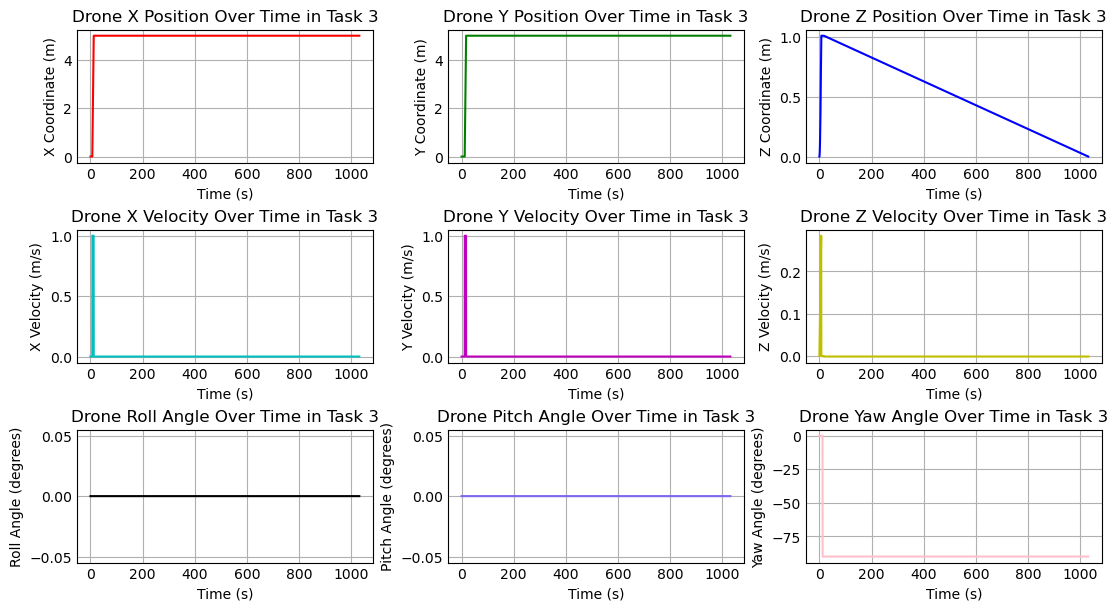

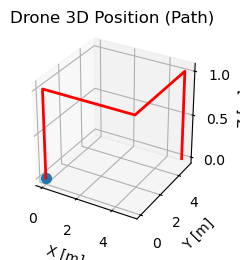

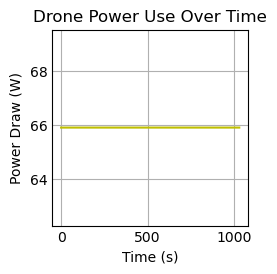

In [19]:
plt.style.use('_mpl-gallery')
r_tx = np.array(r_t).T[0]
r_ty = np.array(r_t).T[1]
r_tz = np.array(r_t).T[2]

v_tx = np.array(v_t).T[0]
v_ty = np.array(v_t).T[1]
v_tz = np.array(v_t).T[2]

phi_t = np.rad2deg(np.array(eulers_t).T[0])
theta_t = np.rad2deg(np.array(eulers_t).T[1])
psi_t = np.rad2deg(np.array(eulers_t).T[2])

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(11, 6), layout="constrained")
axs[0][0].plot(t_t, r_tx, 'r-')
axs[0][0].set_title('Drone X Position Over Time in Task 3', )
axs[0][0].set_xlabel('Time (s)')
axs[0][0].set_ylabel('X Coordinate (m)')

axs[0][1].plot(t_t, r_ty, 'g-')
axs[0][1].set_title('Drone Y Position Over Time in Task 3')
axs[0][1].set_xlabel('Time (s)')
axs[0][1].set_ylabel('Y Coordinate (m)')

axs[0][2].plot(t_t, r_tz, 'b-')
axs[0][2].set_title('Drone Z Position Over Time in Task 3')
axs[0][2].set_xlabel('Time (s)')
axs[0][2].set_ylabel('Z Coordinate (m)')

axs[1][0].plot(t_t, v_tx, 'c-')
axs[1][0].set_title('Drone X Velocity Over Time in Task 3', )
axs[1][0].set_xlabel('Time (s)')
axs[1][0].set_ylabel('X Velocity (m/s)')

axs[1][1].plot(t_t, v_ty, 'm-')
axs[1][1].set_title('Drone Y Velocity Over Time in Task 3')
axs[1][1].set_xlabel('Time (s)')
axs[1][1].set_ylabel('Y Velocity (m/s)')

axs[1][2].plot(t_t, v_tz, 'y-')
axs[1][2].set_title('Drone Z Velocity Over Time in Task 3')
axs[1][2].set_xlabel('Time (s)')
axs[1][2].set_ylabel('Z Velocity (m/s)')

axs[2][0].plot(t_t, phi_t, 'k-')
axs[2][0].set_title('Drone Roll Angle Over Time in Task 3', )
axs[2][0].set_xlabel('Time (s)')
axs[2][0].set_ylabel('Roll Angle (degrees)')

axs[2][1].plot(t_t, theta_t, color = 'mediumslateblue', linestyle = '-')
axs[2][1].set_title('Drone Pitch Angle Over Time in Task 3')
axs[2][1].set_xlabel('Time (s)')
axs[2][1].set_ylabel('Pitch Angle (degrees)')

axs[2][2].plot(t_t, psi_t, color = 'pink', linestyle = '-')
axs[2][2].set_title('Drone Yaw Angle Over Time in Task 3')
axs[2][2].set_xlabel('Time (s)')
axs[2][2].set_ylabel('Yaw Angle (degrees)')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(r_tx, r_ty, r_tz, 'r-', linewidth=2)
ax.scatter(r_tx[0], r_ty[0], r_tz[0], marker='o', s=50)  # start point

# Labels and formatting
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title('Drone 3D Position (Path)')

ax.set_box_aspect([1, 1, 1])  # equal scaling
ax.grid(True)

plt.figure()
plt.plot(t_t, power_t, 'y-')
plt.xlabel('Time (s)')
plt.ylabel('Power Draw (W)')
plt.title('Drone Power Use Over Time')